In [1]:
%matplotlib widget
# %matplotlib inline

import numpy as np
import cmath
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import kvn
import pylib.Chebyschev_coefs as ch
import pylib.qucf_read as qucf_r
import pylib.measurement as mse

11054
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# ---------------------------------------------------------------------------------------------------
# --- Some global parameters ---
# ---------------------------------------------------------------------------------------------------
colors_ = ["b", "r", "g", "magenta", "black"]
path_save_ = "./jupyter-notebooks/NL/results/"
for _ in range(30):
    plt.close()

In [3]:
# ---------------------------------------------------------------------------------------------------
# --- Prepare intial parameters ---
# ---------------------------------------------------------------------------------------------------
mix.reload_module(kvn)

# --- two attractors ---
F_ = lambda x:  - x* (x**2 - 0.25)
# ----------------------------------------

nx_ = 7 
nk_    = 7
k_max_ = 10

# --- Linear x-grid ---
Nx_ = 1 << nx_
x_lin_ = np.linspace(-1.0, 1.0, Nx_)  
dx_    = np.diff(x_lin_)[0]
print("nx: {:d}".format(nx_))

# --- k-grid ---
Nk_    = 1 << nk_
k_     = np.linspace(-k_max_, k_max_, Nk_)
dk_    = np.diff(k_)[0]

_, Aa_, Ah_, Aa_asin_, Ah_asin_ = kvn.construct_UW_matrix_1D(x_lin_, F_, flag_asin = True)

# --- LCHS matrices ---
# REMARK: the normalized matrices Bm_asin_ and Bk_asin_ are the same up to a sign.
Ba_, Bm_, Bk_ = kvn.compute_norm_matrices_LCHS(Aa_, Ah_, k_max_, dk_)
print("\n---")
Ba_asin_, Bm_asin_, Bk_asin_, norm_a_, norm_m_, norm_k_ = \
    kvn.compute_norm_matrices_LCHS_with_output_norm(Aa_asin_, Ah_asin_, k_max_, dk_)

# --- Rescale matrices to the BULK elements of the D-matrices ---
# rescaling at the adge should be corrected afterwards
dd_diags_ref_  = kvn.get_rescaled_diags_BE(Ba_, Bm_, Bk_)
dd_diags_asin_ = kvn.get_rescaled_diags_BE(Ba_asin_, Bm_asin_, Bk_asin_)

nx: 7
Matrix Ba:	 nonsparsity, coefnorm: 2, 6.359e+01
Matrix B_kmax:	 nonsparsity, coefnorm: 3, 1.651e+03
Matrix Bk:	 nonsparsity, coefnorm: 3, 2.600e+01

norm of Ba_norm_:     0.500
norm of B_kmax_norm_: 0.333
norm of Bk_norm_:     0.333

---
Matrix Ba:	 nonsparsity, coefnorm: 2, 2.899e+02
Matrix B_kmax:	 nonsparsity, coefnorm: 3, 7.529e+03
Matrix Bk:	 nonsparsity, coefnorm: 3, 1.186e+02

norm of Ba_norm_:     0.500
norm of B_kmax_norm_: 0.333
norm of Bk_norm_:     0.333



-------------------------------------------------------------------------
--- Ba-norm ---


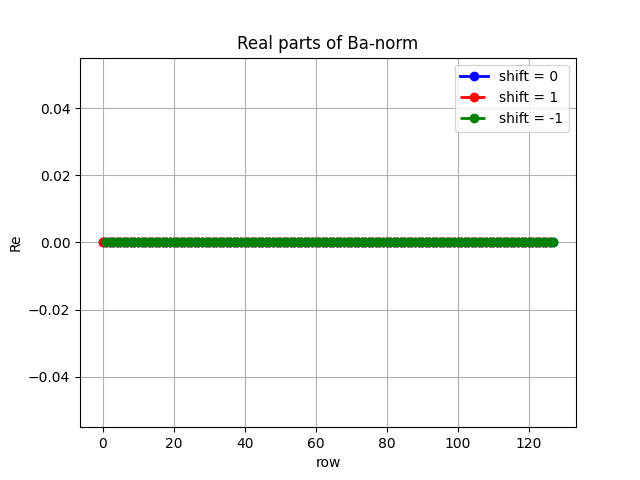

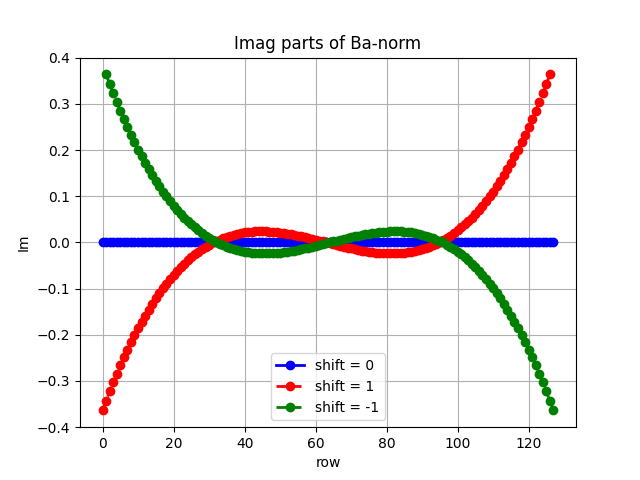


-------------------------------------------------------------------------
--- B-kmax-norm ---


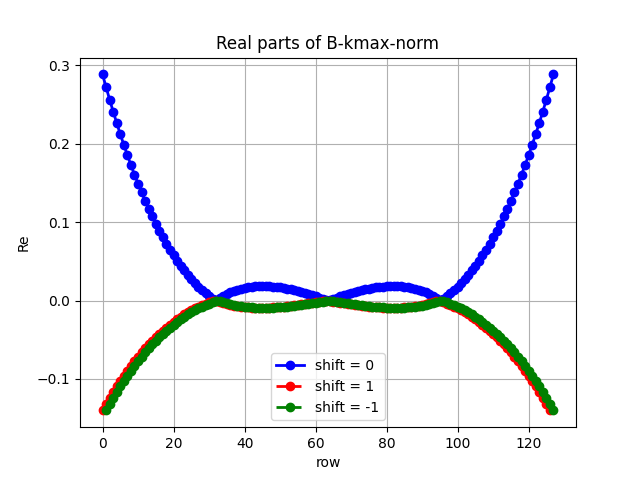

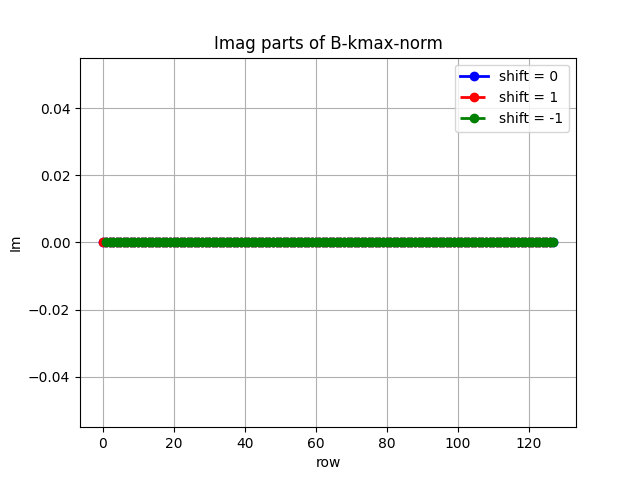

In [4]:
# ---------------------------------------------------------------
# --- Print diagonals of normalized (non-rescaled) matrices ---
# ---------------------------------------------------------------
mix.reload_module(kvn)
def get_plot_diags(flag_save):
    print()
    print("-------------------------------------------------------------------------")
    print("--- Ba-norm ---")
    A_plot, A_name, flag_save_real = Ba_,     "Ba-norm",     False
    kvn.plot_save_diagonals(A_plot, A_name, flag_save, flag_save_real, path_save_)

    print()
    print("-------------------------------------------------------------------------")
    print("--- B-kmax-norm ---")
    A_plot, A_name, flag_save_real = Bk_, "B-kmax-norm", True
    kvn.plot_save_diagonals(A_plot, A_name, flag_save, flag_save_real, path_save_)
    del flag_save, A_plot, A_name, flag_save_real
    return
# ------------------------------------------------------------------
get_plot_diags(flag_save = False)

In [5]:
# -----------------------------------------------------------
# --- Choose the MATRIX and Compute non-normalized SUMS ---
# -----------------------------------------------------------
mix.reload_module(kvn)

sel_matrix = "Ba"  # or "Ba" or "Bk"
flag_asin, flag_Cheb = True, True

# --- Choose the reference matrix ---
if flag_asin:
   if sel_matrix == "Ba":
      A_ref = np.array(Ba_asin_.imag)
   else:
      A_ref = np.array(Bk_asin_.real)
else:
   if sel_matrix == "Ba":
      A_ref = np.array(Ba_.imag)
   else:
      A_ref = np.array(Bk_.real)

# --- Compute diagonals of the reference matrix ---
diag_D_, _ = mix.get_diag(A_ref, i_shift = 0)
diag_R_, _ = mix.get_diag(A_ref, i_shift = 1)
diag_L_, _ = mix.get_diag(A_ref, i_shift = -1)

# --- Compute the sums ---
ar_sD, ar_RR, ar_CR, ar_RL, ar_CL,   sum_D, sum_R_k, sum_L_k, sum_R_a, sum_L_a \
   = kvn.get_sums_UW_KvN_LCHS_matrices_norm(
      x_lin_, F_, norm_a_, norm_k_, dk_,
      flag_asin = flag_asin, flag_Cheb = flag_Cheb
   )

# --- Row indices ---
row_D = range(Nx_)
row_R = range(Nx_-1)
row_L = range(1,Nx_)

sign-D:   eb, ids: 1,  [43, 63, 83]
delta-RR: eb, ids: 0,  [43, 63, 83]
delta-CR: eb, ids: 1,  [42, 62, 82]
delta-RL: eb, ids: 1,  [43, 63, 83]
delta-CL: eb, ids: 0,  [44, 64, 84]


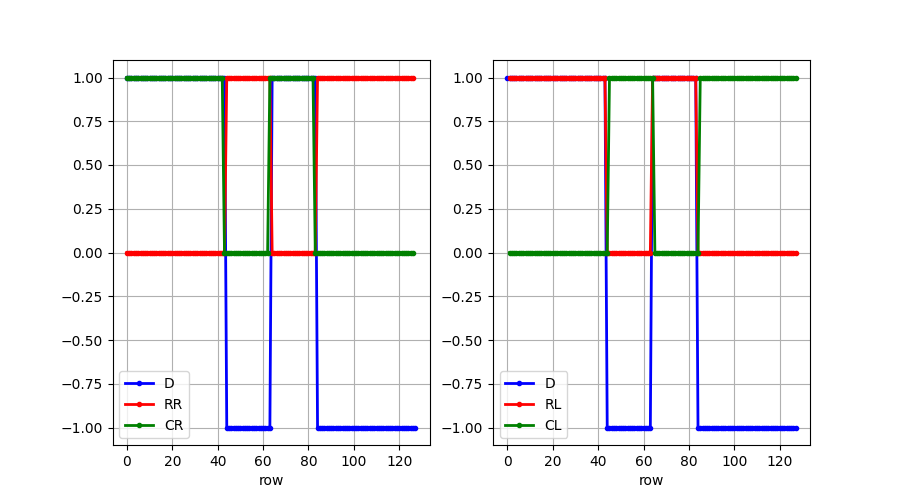

In [7]:
# -------------------------------------------------------------
# --- Plot signs and delta-functions ---
# -------------------------------------------------------------
mix.reload_module(kvn)
def plot_signs_delta():
    def comp_ids(arr, id_sh = 0):
        temp = arr[0]
        ids_res = []  # indices AFTER each the considered array changes value
        for ix in range(len(arr)):
            if arr[ix] != temp:
                temp = arr[ix]
                ids_res.append(ix - 1 + id_sh)
        return ids_res
    # ---------------------------------------------

    # --- Find indices ---
    ids_D = comp_ids(ar_sD)
    ids_RR = comp_ids(ar_RR)
    ids_CR = comp_ids(ar_CR)
    ids_RL = comp_ids(ar_RL, 1)
    ids_CL = comp_ids(ar_CL, 1)
    print("sign-D:   eb, ids: {:d}, ".format(int(ar_sD[0])), ids_D)
    print("delta-RR: eb, ids: {:d}, ".format(int(ar_RR[0])), ids_RR) # = ids_D
    print("delta-CR: eb, ids: {:d}, ".format(int(ar_CR[0])), ids_CR) # = ids_D - 1
    print("delta-RL: eb, ids: {:d}, ".format(int(ar_RL[0])), ids_RL) # = ids_D
    print("delta-CL: eb, ids: {:d}, ".format(int(ar_CL[0])), ids_CL) # = ids_D + 1


    # --- Plotting ---
    fig = plt.figure(figsize=(9,5))
    ax = fig.add_subplot(121)
    ax.plot(row_D,  ar_sD, color='b', marker = ".", linewidth = 2, linestyle='-', label = "D")
    ax.plot(row_R,  ar_RR, color='r', marker = ".", linewidth = 2, linestyle='-', label = "RR")
    ax.plot(row_R,  ar_CR, color='g', marker = ".", linewidth = 2, linestyle='-', label = "CR")
    plt.xlabel('row')
    plt.legend()
    plt.grid(True)

    ax = fig.add_subplot(122)
    ax.plot(row_D,  ar_sD, color='b', marker = ".", linewidth = 2, linestyle='-', label = "D")
    ax.plot(row_L,  ar_RL, color='r', marker = ".", linewidth = 2, linestyle='-', label = "RL")
    ax.plot(row_L,  ar_CL, color='g', marker = ".", linewidth = 2, linestyle='-', label = "CL")
    plt.xlabel('row')
    plt.legend()
    plt.grid(True)
    plt.show()
    return ids_D
# --------------------------------------------------------------------------------------------
ids_D_signs_ = plot_signs_delta()

sum: sum_D: -1.110e-16


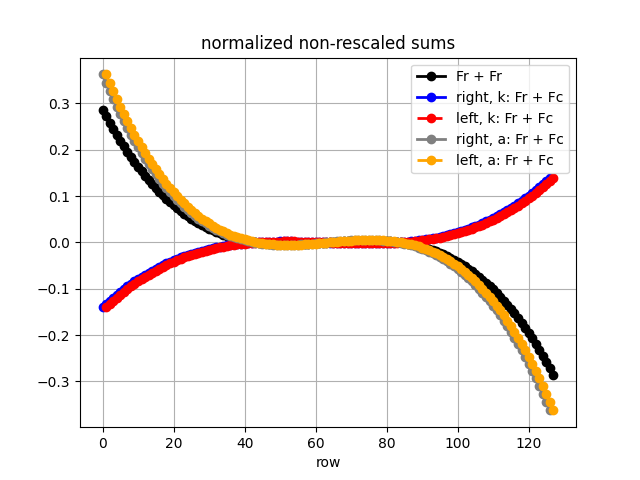

In [8]:
# -------------------------------------------------------------
# --- Plot various sums ---
# -------------------------------------------------------------
mix.reload_module(kvn)
def plot_nonnorm_sums():
    print("sum: sum_D: {:0.3e}".format(np.sum(sum_D)))

    # --- Compara
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(
        row_D,  sum_D, 
        color='black', linewidth = 2, linestyle='-', marker = "o",
        label = "Fr + Fr"
    )

    ax.plot(
        row_R, sum_RR, 
        color='b', linewidth = 2, linestyle='-', marker = "o",
        label = "right: Fr + Fc"
    )
    ax.plot(
        row_R, sum_CR, 
        color='r', linewidth = 2, linestyle='--', marker = "o",
        label = "right: Fr_cc + Fc_cc"
    )  # the same as sum_RR for real F

    ax.plot(
        row_L, sum_RL, 
        color='gray', linewidth = 2, linestyle='-', marker = "o",
        label = "left: Fr + Fc"
    )
    ax.plot(
        row_L, sum_CL, 
        color='orange', linewidth = 2, linestyle='--', marker = "o",
        label = "left: Fr_cc + Fc_cc"
    )  # the same as sum_RL for real F

    plt.xlabel('row')
    plt.legend()
    plt.grid(True)
    plt.show()
    return
def plot_norm_sums():
    print("sum: sum_D: {:0.3e}".format(np.sum(sum_D)))

    # --- Compara
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(
        row_D,  sum_D, 
        color='black', linewidth = 2, linestyle='-', marker = "o",
        label = "Fr + Fr"
    )

    ax.plot(
        row_R, sum_R_k, 
        color='b', linewidth = 2, linestyle='-', marker = "o",
        label = "right, k: Fr + Fc"
    )
    ax.plot(
        row_L, sum_L_k, 
        color='r', linewidth = 2, linestyle='--', marker = "o",
        label = "left, k: Fr + Fc"
    )  # the same as sum_RR for real F

    ax.plot(
        row_R, sum_R_a, 
        color='gray', linewidth = 2, linestyle='-', marker = "o",
        label = "right, a: Fr + Fc"
    )
    ax.plot(
        row_L, sum_L_a, 
        color='orange', linewidth = 2, linestyle='--', marker = "o",
        label = "left, a: Fr + Fc"
    )  # the same as sum_RL for real F

    plt.xlabel('row')
    plt.legend()
    plt.title("normalized non-rescaled sums")
    plt.grid(True)
    plt.show()
    return
# -------------------------------------------------------------------------
plot_norm_sums()

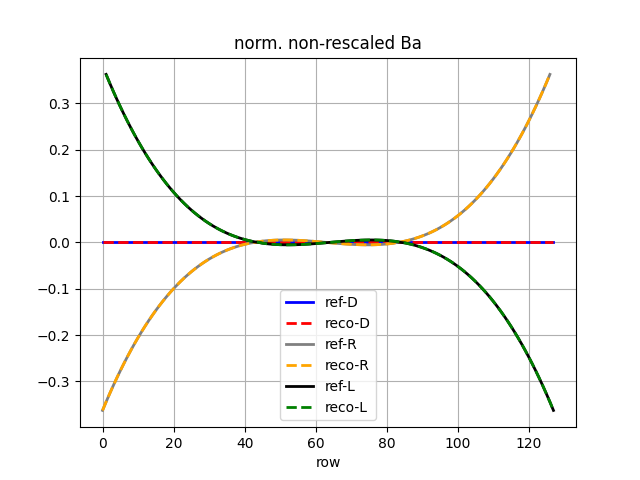

D: ref - reco: 0.000e+00
R: ref - reco: 5.551e-17
L: ref - reco: 5.551e-17


In [9]:
# -----------------------------------------------------------------------
# --- Reconstruct normalized non-rescaled diagonals from the sums ---
# -----------------------------------------------------------------------
mix.reload_module(kvn)
def reconstruct_nonnorm_diags():
    # here, take into account that 
    # sum_RR = sum_CR
    # sum_RL = sum_CL

    # anti-Hermitian part of the matrix (assume that we conside the imaginary part):
    if sel_matrix == "Ba":
        coef_gen = 1./(4.*dx_)
        diag_D_reco = np.zeros(Nx_)
        diag_R_reco = - coef_gen * (ar_RR * sum_RR + ar_CR * sum_RR)
        diag_L_reco =   coef_gen * (ar_RL * sum_RL + ar_CL * sum_RL)

    # Hermitian part of the matrix:
    else:
        coef_gen = -1./(4.*dx_)
        diag_D_reco = -2. * coef_gen * sum_D * ar_sD
        diag_R_reco = coef_gen * (- ar_RR * sum_RR + ar_CR * sum_RR)
        diag_L_reco = coef_gen * (  ar_RL * sum_RL - ar_CL * sum_RL)

    # --- Plotting the diagonals ---
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(row_D, diag_D_,      '-b', linewidth = 2, label = "ref-D")
    ax.plot(row_D, diag_D_reco, '--r', linewidth = 2, label = "reco-D")

    ax.plot(row_R, diag_R_,     color='gray',   linewidth = 2, linestyle='-',  label = "ref-R")
    ax.plot(row_R, diag_R_reco, color='orange', linewidth = 2, linestyle='--', label = "reco-R")

    ax.plot(row_L, diag_L_,     color='black', linewidth = 2, linestyle='-',  label = "ref-L")
    ax.plot(row_L, diag_L_reco, color='green', linewidth = 2, linestyle='--', label = "reco-L")

    plt.xlabel('row')
    plt.title(sel_matrix)
    plt.legend()
    plt.grid(True)
    plt.show()

    print("D: ref - reco: {:0.3e}".format(np.max(np.abs(diag_D_ - diag_D_reco))))
    print("R: ref - reco: {:0.3e}".format(np.max(np.abs(diag_R_ - diag_R_reco))))
    print("L: ref - reco: {:0.3e}".format(np.max(np.abs(diag_L_ - diag_L_reco))))
    return
def reconstruct_norm_diags():
    # anti-Hermitian part of the matrix (assume that we conside the imaginary part):
    if sel_matrix == "Ba":
        diag_D_reco = np.zeros(Nx_)
        diag_R_reco = - (ar_RR * sum_R_a + ar_CR * sum_R_a)
        diag_L_reco =   (ar_RL * sum_L_a + ar_CL * sum_L_a)

        # diag_R_reco = -np.array(sum_R_a)
        # diag_L_reco = np.array(sum_L_a)

    # Hermitian part of the matrix:
    else:
        diag_D_reco = sum_D * ar_sD
        diag_R_reco = - ar_RR * sum_R_k + ar_CR * sum_R_k
        diag_L_reco =   ar_RL * sum_L_k - ar_CL * sum_L_k

    # --- Plotting the diagonals ---
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(row_D, diag_D_,      '-b', linewidth = 2, label = "ref-D")
    ax.plot(row_D, diag_D_reco, '--r', linewidth = 2, label = "reco-D")

    ax.plot(row_R, diag_R_,     color='gray',   linewidth = 2, linestyle='-',  label = "ref-R")
    ax.plot(row_R, diag_R_reco, color='orange', linewidth = 2, linestyle='--', label = "reco-R")

    ax.plot(row_L, diag_L_,     color='black', linewidth = 2, linestyle='-',  label = "ref-L")
    ax.plot(row_L, diag_L_reco, color='green', linewidth = 2, linestyle='--', label = "reco-L")

    plt.xlabel('row')
    plt.title("norm. non-rescaled " + sel_matrix)
    plt.legend()
    plt.grid(True)
    plt.show()

    print("D: ref - reco: {:0.3e}".format(np.max(np.abs(diag_D_ - diag_D_reco))))
    print("R: ref - reco: {:0.3e}".format(np.max(np.abs(diag_R_ - diag_R_reco))))
    print("L: ref - reco: {:0.3e}".format(np.max(np.abs(diag_L_ - diag_L_reco))))
    return
# -----------------------------------------------------------------------------------------
reconstruct_norm_diags()

In [10]:
# ---------------------------------------------------------------------
# --- GET rescaled sums (because of the influence of the OF oracle) ---
# --- Here, the rescaling is performed only to bulk points          ---
# ---------------------------------------------------------------------
def get_rescaled_sums():
    # rescaled sums for Bk:
    coef_R_k, coef_D = 0.250, 0.500
    sum_D_rs   = sum_D   / coef_D
    sum_R_k_rs = sum_R_k / coef_R_k

    # rescaled sum for Ba:
    coef_R_a = 0.500
    sum_R_a_rs = sum_R_a / coef_R_a
    return sum_D_rs, sum_R_k_rs, sum_R_a_rs
# ----------------------------------------------------------------------------
sum_D_rs, sum_R_k_rs, sum_R_a_rs = get_rescaled_sums()

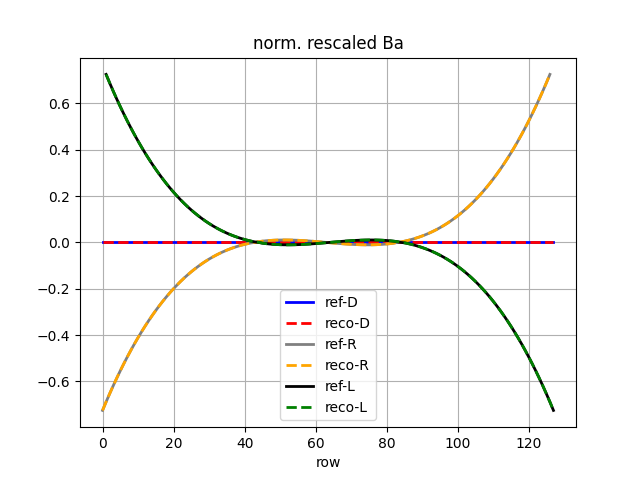

D: ref - reco: 0.000e+00
R: ref - reco: 1.110e-16
L: ref - reco: 1.110e-16


In [13]:
# -----------------------------------------------------------------------
# --- Reconstruct normalized rescaled diagonals from the sums ---
# -----------------------------------------------------------------------
def reconstruct_norm_rescaled_diags():
    # anti-Hermitian part of the matrix (assume that we conside the imaginary part):
    if sel_matrix == "Ba":
        diag_D_reco = np.zeros(Nx_)
        diag_R_reco = - (ar_RR * sum_R_a_rs + ar_CR * sum_R_a_rs)
        diag_L_reco =   (ar_RL * sum_R_a_rs + ar_CL * sum_R_a_rs)

        diag_D_ref = np.zeros(Nx_)
        diag_R_ref = dd_diags_asin_["diag_A_p1"]
        diag_L_ref = dd_diags_asin_["diag_A_m1"]

    # Hermitian part of the matrix:
    else:
        diag_D_reco = sum_D_rs * ar_sD
        diag_R_reco = - ar_RR * sum_R_k_rs + ar_CR * sum_R_k_rs
        diag_L_reco =   ar_RL * sum_R_k_rs - ar_CL * sum_R_k_rs

        diag_D_ref = dd_diags_asin_["diag_k_00"]
        diag_R_ref = dd_diags_asin_["diag_k_p1"]
        diag_L_ref = dd_diags_asin_["diag_k_m1"]

    # --- Plotting the diagonals ---
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(row_D, diag_D_ref,      '-b', linewidth = 2, label = "ref-D")
    ax.plot(row_D, diag_D_reco, '--r', linewidth = 2, label = "reco-D")

    ax.plot(row_R, diag_R_ref,     color='gray',   linewidth = 2, linestyle='-',  label = "ref-R")
    ax.plot(row_R, diag_R_reco, color='orange', linewidth = 2, linestyle='--', label = "reco-R")

    ax.plot(row_L, diag_L_ref,     color='black', linewidth = 2, linestyle='-',  label = "ref-L")
    ax.plot(row_L, diag_L_reco, color='green', linewidth = 2, linestyle='--', label = "reco-L")

    plt.xlabel('row')
    plt.title("norm. rescaled " + sel_matrix)
    plt.legend()
    plt.grid(True)
    plt.show()

    print("D: ref - reco: {:0.3e}".format(np.max(np.abs(diag_D_ref - diag_D_reco))))
    print("R: ref - reco: {:0.3e}".format(np.max(np.abs(diag_R_ref - diag_R_reco))))
    print("L: ref - reco: {:0.3e}".format(np.max(np.abs(diag_L_ref - diag_L_reco))))
    return
# -----------------------------------------------------------------------------------------
reconstruct_norm_rescaled_diags()

ref - check: 4.185e-17


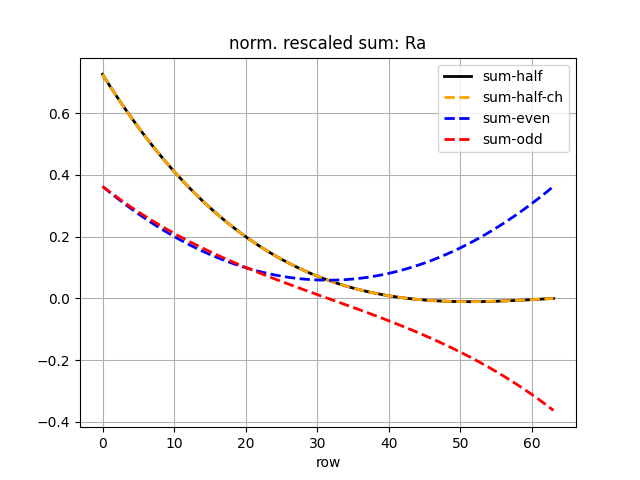

In [18]:
# ----------------------------------------------------------------------
# --- Choose a sum ---
# ----------------------------------------------------------------------
mix.reload_module(kvn)
from scipy import interpolate
def get_extr_odd_even_sum():
    # --- Choosing a sum ---
    sum_ref = None
    row_ref = None
    if sel_sum_ == "D":
        row_ref = row_D
        sum_ref = np.array(sum_D_rs)
    if sel_sum_ == "Rk":
        row_ref = row_R
        sum_ref = np.array(sum_R_k_rs) 
    if sel_sum_ == "Ra":
        row_ref = row_R
        sum_ref = np.array(sum_R_a_rs)

    # --- Interpolate the sum ---
    f_interp = interpolate.CubicSpline(row_ref, sum_ref)
    sum_extr = f_interp(row_D)

    # --- Take the half ---
    if sel_half_ == 0: # left
        id_end = Nx_//2
        row_half = row_D[:id_end]
        sum_half = sum_extr[:id_end]
    else: # right
        id_b = Nx_//2
        row_half = row_D[id_b:-1]
        sum_half = sum_extr[id_b:-1]
    del sum_extr

    # --- Find the even abd odd parts ---
    sum_extr_even = 0.5 * (sum_half + sum_half[::-1])
    sum_extr_odd  = 0.5 * (sum_half - sum_half[::-1])
    sum_half_ch = sum_extr_even + sum_extr_odd

    print("ref - check: {:0.3e}".format(
        np.max(np.abs(sum_half - sum_half_ch))
    ))

    # --- Plot the extrapolated sum ---
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(
        row_half, sum_half, 
        color='black', linewidth = 2, linestyle='-',  
        label = "sum-half"
    )
    ax.plot(
        row_half, sum_half_ch,  
        color='orange', linewidth = 2, linestyle='--',  
        label = "sum-half-ch"
    )

    ax.plot(
        row_half, sum_extr_even, 
        color='b', linewidth = 2, linestyle='--',  
        label = "sum-even"
    )
    ax.plot(
        row_half, sum_extr_odd, 
        color='r', linewidth = 2, linestyle='--',  
        label = "sum-odd"
    )
    plt.xlabel('row')
    plt.title("norm. rescaled sum: " + sel_sum_)
    plt.legend()
    plt.grid(True)
    plt.show()
    if sel_sum_ == "D": 
        return sum_D_rs, None, None # no LCU
    else:
        return sum_half, sum_extr_odd, sum_extr_even
# ----------------------------------------------------------------------
sel_sum_ = "Ra"  # "D", "Rk", "Ra" (independent of the chosen matrix)
sel_half_ = 0   # 0 or 1
f_goal_, f_goal_odd_, f_goal_even_ = get_extr_odd_even_sum()


--------------------------------------------------------------------
--- Chebyschev coefficients ---
--------------------------------------------------------------------

--------------------------------------------------------------------
--- Computing Chebyschev coefficients ---
--------------------------------------------------------------------
Chosen profile: Ra
Chosen parity: 0

Minimization method is used.
Computation status:  2.971228421703408e-31

Chosen polynomial's degree:	 64
Number of coefficients:		 32
max. abs. error: 2.220e-16


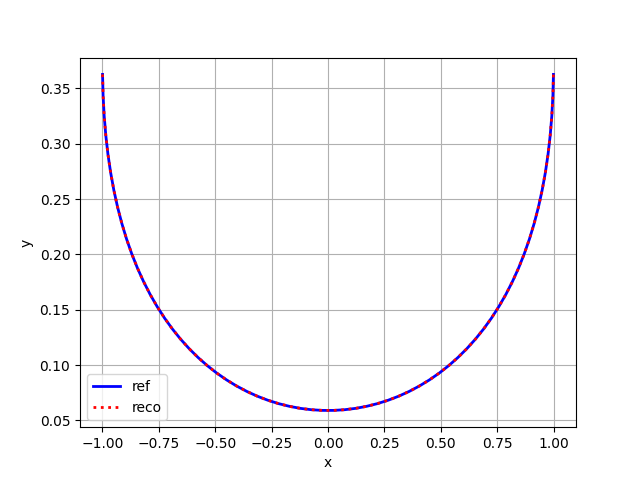

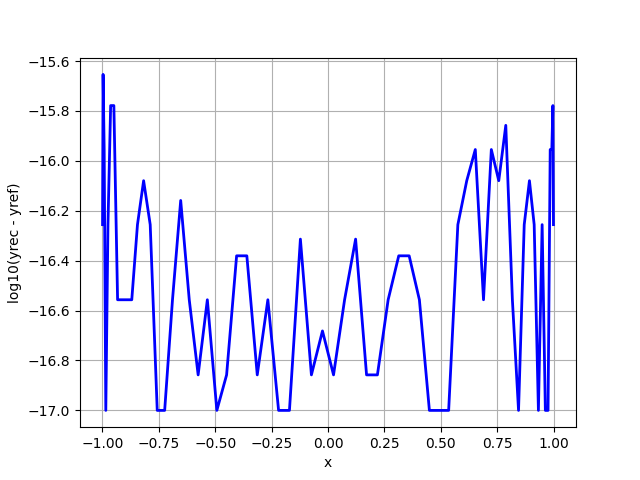

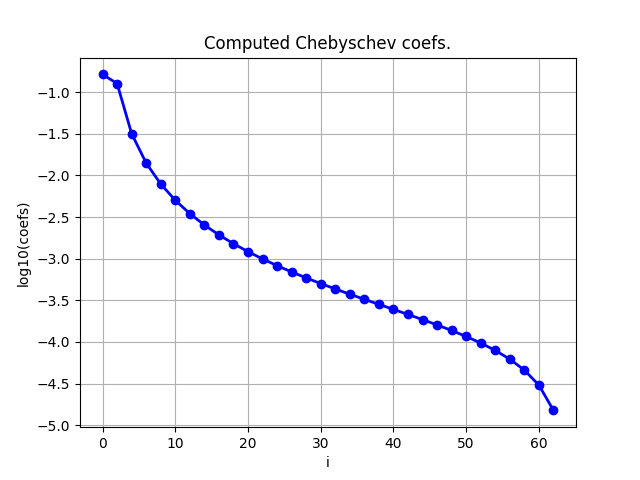

write coefficients to:
 ./jupyter-notebooks/NL/BE/coefs//Ra_even_eps15.hdf5
Chosen profile: Ra
Chosen parity: 1

Minimization method is used.
Computation status:  5.2818102103350775e-31

Chosen polynomial's degree:	 64
Number of coefficients:		 32
max. abs. error: 4.996e-16


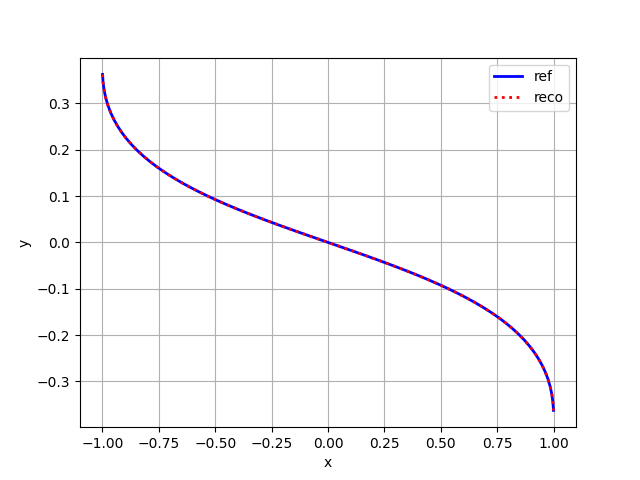

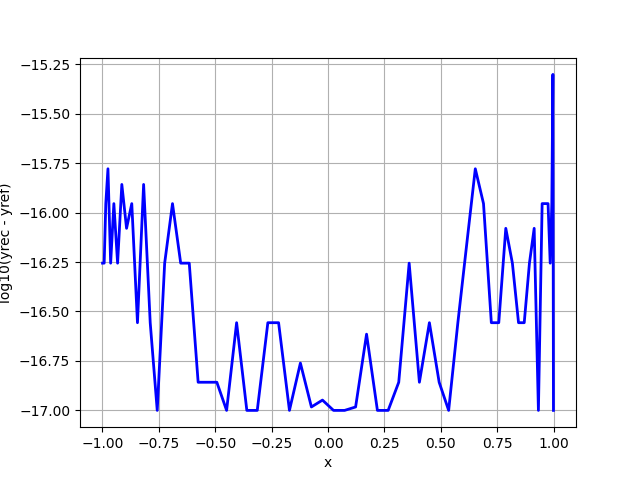

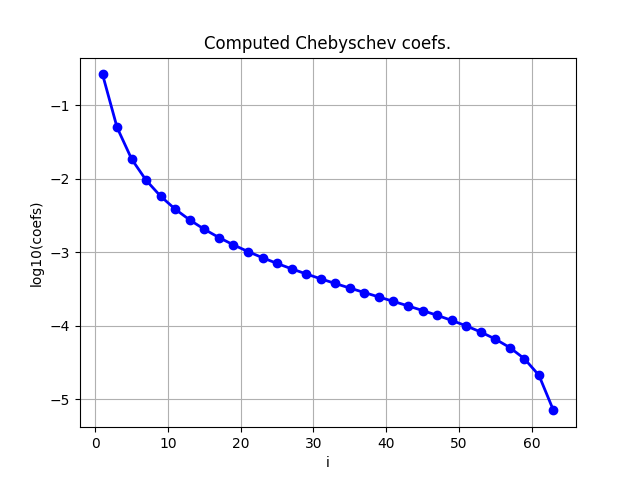

write coefficients to:
 ./jupyter-notebooks/NL/BE/coefs//Ra_odd_eps15.hdf5


In [26]:
# ---------------------------------------------------------------
# --- Compute QSVT angles for the chosen sum ---
# ---------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(ch)
mix.reload_module(kvn)

# -----------------------------------------------------------------------------------
def compute_Cheb_coefs(diag_ch, parity_1, Nd, flag_save_hdf5, flag_save_dat):
    sel_method = 0

    oo_ch_ = ch.Ch_()
    oo_ch_.choose_method(sel_method)
    oo_ch_.choose_func(
        -1, 0.0, 
        profile_in = diag_ch,
        name_prof  = sel_sum_,
        parity_in  = parity_1,
        path_root_in = "./jupyter-notebooks/NL/BE/coefs/"
    )
    oo_ch_.compute_Ch(Nd)
    oo_ch_.plot_reconstructed_function()
    oo_ch_.plot_errors()
    oo_ch_.plot_coefficients()

    if flag_save_hdf5:
        fname_ch = sel_sum_
        if parity_1 == 0:
            fname_ch += "_even"
        else:
            fname_ch += "_odd"
        oo_ch_.save_coefficients(fname_ch)

    # if flag_save_dat:
    #     # - Chebyschev coefficients -
    #     fname = "{:s}_Cheb{:d}.dat".format(key_diag_, oo_ch_.Nc_)
    #     mix.save_dat_plot_1d_file(
    #         path_save_ + "/" + fname, 
    #         range(oo_ch_.Nc_), 
    #         np.log10(np.abs(oo_ch_.coefs_))
    #     )
    return oo_ch_

# -----------------------------------------------------------------------------------
def test_recon_sin(oo, flag_save_err):
    range_x = range(len(diag_ch_))

    y_ref = np.array(dd_diags_ref_[key_diag_])
    y_rec = oo_temp_ch.get_rec_y_sin_x()
    y_rec *= factor_global_

    # --- Error ---
    log_err = np.zeros(len(y_rec))
    for ii in range(len(y_rec)):
        err1 = np.abs(y_rec[ii] - y_ref[ii])
        if err1 < 1e-17:
            err1 = 1e-17
        log_err[ii] = np.log10(err1)

    # --- PLOTTING ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range_x, y_ref, "-",  color="b", linewidth = 2, label = "ref-x")
    ax.plot(range_x, y_rec, "--", color="r", linewidth = 2, label = "rec-sinx")
    plt.xlabel('i')
    plt.ylabel("diags")
    plt.legend()
    plt.grid(True)
    plt.show() 

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range_x, log_err,  color="b", linewidth = 2, linestyle='-')
    plt.xlabel('i')
    plt.ylabel("log10(error)")
    plt.grid(True)
    plt.show() 

    if flag_save_err:
        # - errors -
        fname = "{:s}_ERR_Nc{:d}.dat".format(key_diag_, oo.Nc_)
        mix.save_dat_plot_1d_file(path_save_ + "/" + fname, range_x, log_err)
    return

# -----------------------------------------------------------------------------------
# --- Find the Chebyschev coefficients of the series ---
# -----------------------------------------------------------------------------------
print()
print("--------------------------------------------------------------------")
print("--- Chebyschev coefficients ---")
print("--------------------------------------------------------------------")
flag_save_hdf5 = True
flag_save_dat_coefs = False
flag_save_dat_err = False

# REMARK: if Cheb = True, asin = False, then just a few Nd (e.g. Nd = 4) is necessary
Nd = 64

print()
print("--------------------------------------------------------------------")
print("--- Computing Chebyschev coefficients ---")
print("--------------------------------------------------------------------")
oo_temp_D = None
oo_temp_even = None
oo_temp_odd = None
if sel_sum_ == "D":
    oo_temp_D = compute_Cheb_coefs(
        f_goal_, 1, Nd, 
        flag_save_hdf5, 
        flag_save_dat_coefs
    )
else:
    oo_temp_even = compute_Cheb_coefs(
        f_goal_even_, 0, Nd, 
        flag_save_hdf5, 
        flag_save_dat_coefs
    )
    oo_temp_odd = compute_Cheb_coefs(
        f_goal_odd_, 1, Nd, 
        flag_save_hdf5, 
        flag_save_dat_coefs
    )




# print()
# print("--------------------------------------------------------------------")
# print("--- Reconstructed profile ---")
# print("--------------------------------------------------------------------")
# test_recon_sin(oo_temp_ch, flag_save_dat_err)

# --------------------------------------------
# ratio factors:
# Ba-m1: 4.555319024641e+00
# Ba-p1: 4.555319011284e+00
# ---
# Bm-m1: 4.557453940854e+00
# Bm-00: 4.560220926459e+00
# Bm-p1: 4.557453940854e+00
# ---
# Bk-m1: 4.557453940511e+00
# Bk-00: 4.560220912593e+00
# Bk-p1: 4.557453940511e+00

del Nd, flag_save_hdf5, flag_save_dat_coefs, flag_save_dat_err


--- Reading D-matrices for BE oracles of the matrix Ah for various nx.
Reading the matrix from: Dk-n4.hdf5
from the path: ../QuCF/simulations/LCHS/KvN/BE-2/UD/
date of the simulation:  06-11-2024 17:59:32
matrix name:  U_BE_kmax
N = 16

--- Reading D-matrices for BE oracles of the matrix Aa for various nx.
Reading the matrix from: Da-n4.hdf5
from the path: ../QuCF/simulations/LCHS/KvN/BE-2/UD/
date of the simulation:  06-11-2024 18:07:14
matrix name:  U_BE_a
N = 16

--- Reading D-matrices for BE oracles of the matrix Ah for various nx.
Reading the matrix from: Dk-n7.hdf5
from the path: ../QuCF/simulations/LCHS/KvN/BE-2/UD/
date of the simulation:  06-11-2024 17:57:31
matrix name:  U_BE_kmax
N = 128

--- Reading D-matrices for BE oracles of the matrix Aa for various nx.
Reading the matrix from: Da-n7.hdf5
from the path: ../QuCF/simulations/LCHS/KvN/BE-2/UD/
date of the simulation:  06-11-2024 18:07:44
matrix name:  U_BE_a
N = 128


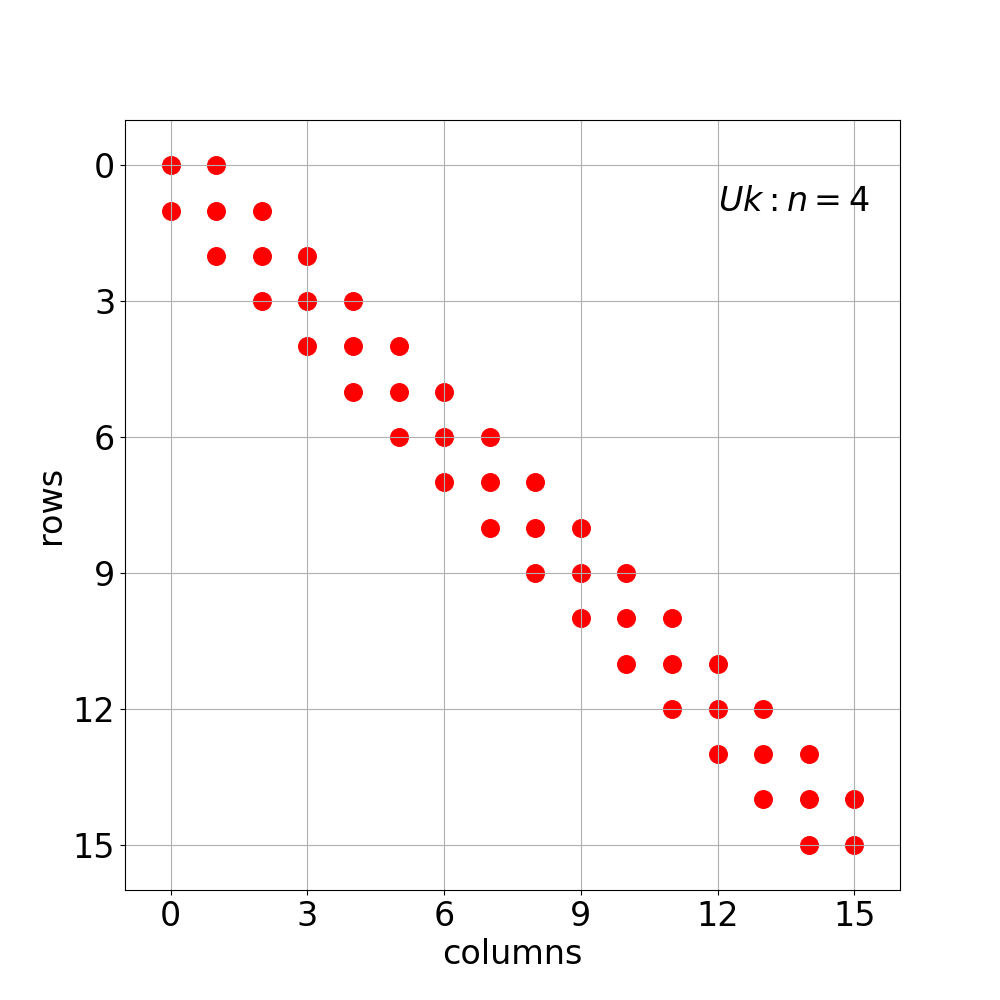

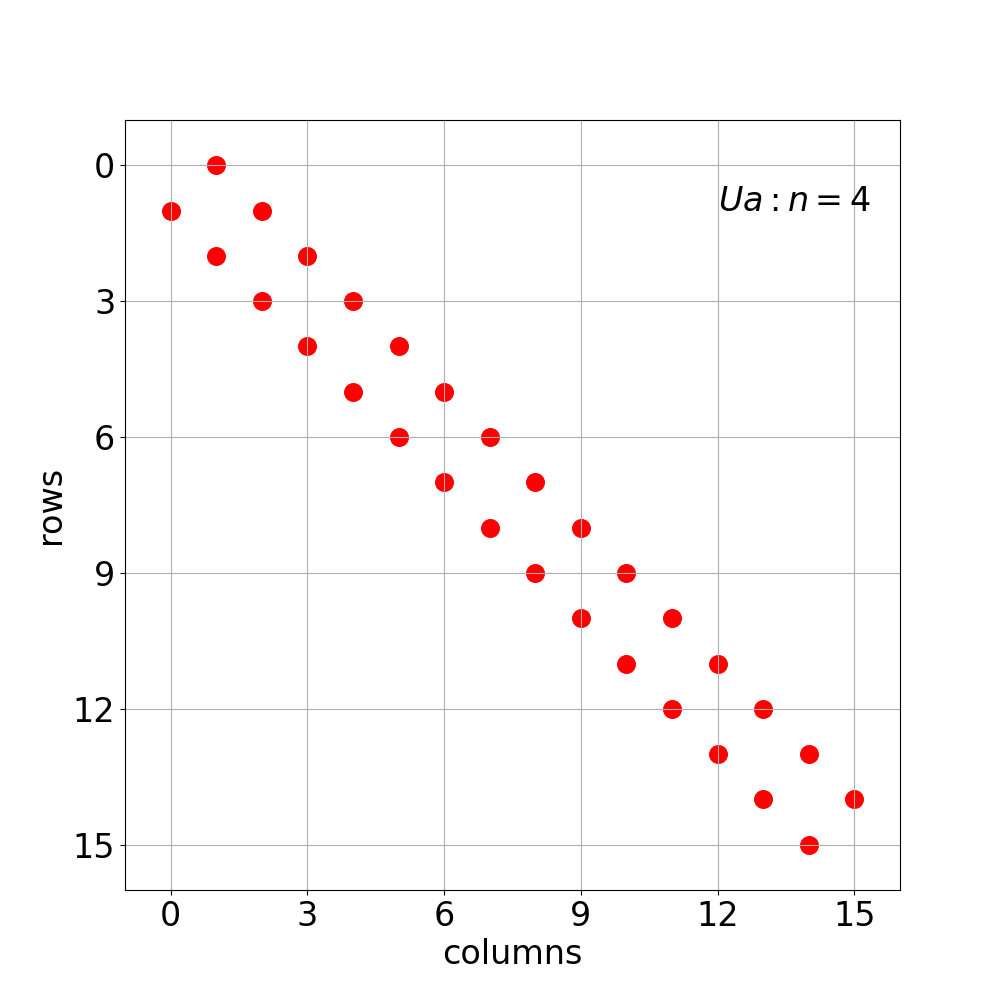

--- Elements in Dk in the diagonal 1 ---

 0.354  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250 

 0.354  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.

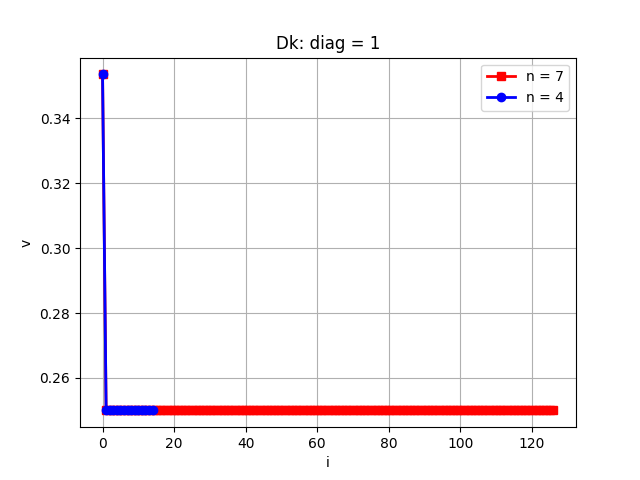

In [16]:
# ***********************************************************************************************************
# ***********************************************************************************************************
# ***********************************************************************************************************
# -------------------------------------------------------------------------
# --- Read D-matrices computed by the QuCF ---
# -------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(qucf_r)
mix.reload_module(kvn)
def reading_UD_matrices():
    path_D = "../QuCF/simulations/LCHS/KvN/BE-2/UD/"
    diff_n = [4, 7]
    dds_k = []
    dds_a = []
    for ii in range(len(diff_n)):
        print()
        print("--- Reading D-matrices for BE oracles of the matrix Ah for various nx.")
        fname_loc = "Dk-n{:d}.hdf5".format(diff_n[ii])
        dd_loc    = qucf_r.read_matrix_sparse(path_D, fname_loc) 
        dds_k.append(dd_loc)

        print()
        print("--- Reading D-matrices for BE oracles of the matrix Aa for various nx.")
        fname_loc = "Da-n{:d}.hdf5".format(diff_n[ii])
        dd_loc    = qucf_r.read_matrix_sparse(path_D, fname_loc) 
        dds_a.append(dd_loc)

    # --- Plot structures of D-matrices computed by the QuCF ---
    id_plot = 0
    dds_k[id_plot]["A"].plot_structure("Uk: n={:d}".format(diff_n[id_plot]))
    dds_a[id_plot]["A"].plot_structure("Ua: n={:d}".format(diff_n[id_plot]))
    return diff_n, dds_k, dds_a
# -----------------------------------------------------------------------------------
def print_plot_D_elements(id_shift, dds_print, str_matrix, flag_plot = True):
    colors = ["b", "r", "g"]
    markers = ["o", "s", "*"]

    # --- Printing ---
    print("--- Elements in {:s} in the diagonal {:d} ---".format(str_matrix, id_shift))
    print()
    for ii in range(len(diff_n)):
        mix.print_array(
            kvn.get_diag(dds_print[ii]["A"].form_dense_matrix(), id_shift)[0].real,
            n_in_row = 8,
            ff=[6, 3, "f"]
        )
        print()

    # --- Plotting ---
    if flag_plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        for i1 in range(len(diff_n)):
            ii = len(diff_n) - i1 - 1
            n1 = diff_n[ii]
            ax.plot(
                np.array(range((1<<n1) - np.abs(id_shift))), 
                kvn.get_diag(dds_print[ii]["A"].form_dense_matrix(), id_shift)[0].real, 
                color=colors[ii], linewidth = 2, linestyle='-', marker = markers[ii],
                label = "n = {:d}".format(n1)
            )
        plt.xlabel('i')
        plt.ylabel("v")
        plt.title(str_matrix + ": diag = {:d}".format(id_shift))
        plt.legend()
        plt.grid(True)
        plt.show() 
# -----------------------------------------------------------------------------------
# ---
diff_n, dds_k, dds_a = reading_UD_matrices()

# ---
id_diag = 1
print_plot_D_elements(id_diag, list(dds_k), "Dk")
# print_plot_D_elements(id_diag, list(dds_a), "Da")
del id_diag

In [ ]:
# ----------------------------------------------------------------------
# --- Take the square root of the first half of the symmetric sum ---
# ----------------------------------------------------------------------
mix.reload_module(kvn)
from scipy import interpolate
def get_sqrt_odd_even_sum():
    flag_plot_sqrt = True

    # --- Choosing a sum ---
    sum_ref = None
    row_ref = None
    if sel_sum_ == "D":
        row_ref = row_D
        sum_ref = np.array(sum_D_rs, dtype = complex)
    if sel_sum_ == "Rk":
        row_ref = row_R
        sum_ref = np.array(sum_R_k_rs, dtype = complex) 
    if sel_sum_ == "Ra":
        row_ref = row_R
        sum_ref = np.array(sum_R_a_rs, dtype = complex)
        id_end = Nx_//2
        sum_sqrt = np.sqrt(sum_ref)



    # --- Interpolate the sum ---
    sum_even = 0.5 * (sum_sqrt + sum_sqrt[::-1])
    sum_odd  = 0.5 * (sum_sqrt - sum_sqrt[::-1])
    sum_sqrt_ch = sum_odd + sum_even

    # --- Print some data ---
    print("sqrt - sqrt_check: {:0.3e}".format(
        np.max(np.abs(sum_sqrt - sum_sqrt_ch))
    ))

    # # --- Plot the sqrt sum ---
    if flag_plot_sqrt:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(
            row_ref, sum_sqrt.real, 
            color='black', linewidth = 2, linestyle='-',  
            label = "sum-sqrt.real"
        )
        ax.plot(
            row_ref, sum_sqrt.imag, 
            color='gray', linewidth = 2, linestyle='-',  
            label = "sum-sqrt.imag"
        )


        ax.plot(
            row_ref, sum_even.real, 
            color='b', linewidth = 2, linestyle='--',  
            label = "sum-even.real"
        )
        ax.plot(
            row_ref, sum_odd.real, 
            color='r', linewidth = 2, linestyle='--',  
            label = "sum-odd.real"
        )

        ax.plot(
            row_ref, sum_even.imag, 
            color='green', linewidth = 2, linestyle=':',  
            label = "sum-even.imag"
        )
        ax.plot(
            row_ref, sum_odd.imag, 
            color='orange', linewidth = 2, linestyle=':',  
            label = "sum-odd.imag"
        )
        plt.xlabel('row')
        plt.title("norm. rescaled sum: " + sel_sum_)
        plt.legend()
        plt.grid(True)
        plt.show()
    return sum_sqrt, sum_odd, sum_even
# ----------------------------------------------------------------------
sel_sum_ = "Ra"  # "D", "Rk", "Ra" (independent of the chosen matrix)
sum_sqrt_, sum_sqrt_odd_, sum_sqrt_even_ = get_sqrt_odd_even_sum()

In [ ]:
# ----------------------------------------------------------------------
# --- Take the square root of the first half of the symmetric sum ---
# ----------------------------------------------------------------------
mix.reload_module(kvn)
from scipy import interpolate
def get_sqrt_odd_even_sum():
    flag_plot_half = False
    flag_plot_sqrt = True

    # --- Choosing a sum ---
    sum_ref = None
    row_ref = None
    if sel_sum_ == "D":
        row_ref = row_D
        sum_ref = np.array(sum_D_rs, dtype = complex)
    if sel_sum_ == "Rk":
        row_ref = row_R
        sum_ref = np.array(sum_R_k_rs, dtype = complex) 
    if sel_sum_ == "Ra":
        row_ref = row_R
        sum_ref = np.array(sum_R_a_rs, dtype = complex)
        id_end = Nx_//2
        sum_half = sum_ref[:id_end]
        sum_half_sqrt = np.sqrt(sum_half)

    # ---
    row_half = row_ref[:id_end]

    # reflected half signal (just tot recheck)
    sum_refle = sum_ref[:id_end]
    sum_refle = -sum_refle[::-1]

    # --- Interpolate the sum ---
    sum_even = 0.5 * (sum_half_sqrt + sum_half_sqrt[::-1])
    sum_odd  = 0.5 * (sum_half_sqrt - sum_half_sqrt[::-1])
    sum_half_sqrt_ch = sum_odd + sum_even

    # --- Print some data ---
    print("half[-1] = {:20.3e}".format(sum_half[-1]))
    print("sqrt - sqrt_check: {:0.3e}".format(
        np.max(np.abs(sum_half_sqrt - sum_half_sqrt_ch))
    ))

    # --- Plot signal and its halfs ---
    if flag_plot_half:
        fig = plt.figure()
        ax = fig.add_subplot(111)

        ax.plot(
            row_ref, sum_ref.real, 
            color='black', marker = "o", linewidth = 2, linestyle='-',  
            label = "sum-ref"
        )
        ax.plot(
            row_half, sum_half.real,  
            color='orange', marker = "o", linewidth = 2, linestyle='--',  
            label = "sum-half"
        )
        ax.plot(
            id_end+np.array(row_ref[:id_end])-1, sum_refle,  
            color='red', marker = "s", linewidth = 2, linestyle='--',  
            label = "sum-half-reflected"
        )
        plt.xlabel('row')
        plt.title("norm. rescaled sum: " + sel_sum_)
        plt.legend()
        plt.grid(True)
        plt.show()

    # # --- Plot the sqrt sum ---
    if flag_plot_sqrt:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(
            row_half, sum_half_sqrt.real, 
            color='black', linewidth = 2, linestyle='-',  
            label = "sum-sqrt.real"
        )
        ax.plot(
            row_half, sum_half_sqrt_ch.real,  
            color='orange', linewidth = 2, linestyle='--',  
            label = "sum-sqrt-ch.real"
        )

        ax.plot(
            row_half, sum_half_sqrt.imag, 
            color='black', linewidth = 2, linestyle=':',  
            label = "sum-sqrt.imag"
        )
        ax.plot(
            row_half, sum_half_sqrt_ch.imag,  
            color='orange', linewidth = 2, linestyle=':',  
            label = "sum-sqrt-ch.imag"
        )

        ax.plot(
            row_half, sum_even.real, 
            color='b', linewidth = 2, linestyle='--',  
            label = "sum-even.real"
        )
        ax.plot(
            row_half, sum_odd.real, 
            color='r', linewidth = 2, linestyle='--',  
            label = "sum-odd.real"
        )

        ax.plot(
            row_half, sum_even.imag, 
            color='b', linewidth = 2, linestyle=':',  
            label = "sum-even.imag"
        )
        ax.plot(
            row_half, sum_odd.imag, 
            color='r', linewidth = 2, linestyle=':',  
            label = "sum-odd.imag"
        )
        plt.xlabel('row')
        plt.title("norm. rescaled sum: " + sel_sum_)
        plt.legend()
        plt.grid(True)
        plt.show()
    return sum_half_sqrt, sum_odd, sum_even
# ----------------------------------------------------------------------
sel_sum_ = "Ra"  # "D", "Rk", "Ra" (independent of the chosen matrix)
sum_sqrt_, sum_sqrt_odd_, sum_sqrt_even_ = get_sqrt_odd_even_sum()

In [ ]:
# ----------------------------------------------------------------------
# --- Choose a sum ---
# ----------------------------------------------------------------------
mix.reload_module(kvn)
from scipy import interpolate
def get_extr_odd_even_sum():
    # --- Choosing a sum ---
    sum_ref = None
    row_ref = None
    if sel_sum_ == "D":
        row_ref = row_D
        sum_ref = np.array(sum_D_rs)
    if sel_sum_ == "Rk":
        row_ref = row_R
        sum_ref = np.array(sum_R_k_rs) 
    if sel_sum_ == "Ra":
        row_ref = row_R
        sum_ref = np.array(sum_R_a_rs)

    # --- Interpolate the sum ---
    f_interp = interpolate.CubicSpline(row_ref, sum_ref)
    sum_extr = f_interp(row_D)
    sum_extr_even = 0.5 * (sum_extr + sum_extr[::-1])
    sum_extr_odd  = 0.5 * (sum_extr - sum_extr[::-1])
    sum_RR_extr_ch = sum_extr_even + sum_extr_odd

    # --- Plot the extrapolated sum ---
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(
        row_D, sum_extr, 
        color='black', linewidth = 2, linestyle='-',  
        label = "sum-extr"
    )
    ax.plot(
        row_D, sum_RR_extr_ch,  
        color='orange', linewidth = 2, linestyle='--',  
        label = "sum-extr-ch"
    )

    ax.plot(
        row_D, sum_extr_even, 
        color='b', linewidth = 2, linestyle='--',  
        label = "sum-even"
    )
    ax.plot(
        row_D, sum_extr_odd, 
        color='r', linewidth = 2, linestyle='--',  
        label = "sum-odd"
    )
    
    print("ref - check: {:0.3e}".format(
        np.max(np.abs(sum_extr - sum_RR_extr_ch))
    ))

    plt.xlabel('row')
    plt.title("norm. rescaled sum: " + sel_sum_)
    plt.legend()
    plt.grid(True)
    plt.show()
    if sel_sum_ == "D":
        return sum_D_rs, None, None
    else:
        return sum_extr, sum_extr_odd, sum_extr_even
# ----------------------------------------------------------------------
sel_sum_ = "Ra"  # "D", "Rk", "Ra" (independent of the chosen matrix)
sum_extr_, sum_extr_odd_, sum_extr_even_ = get_extr_odd_even_sum()